In [1]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from nltk import tokenize
import nltk
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout, Flatten
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix
from keras import Sequential
import nltk

In [2]:
##set to .env
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 40     # maximum number of letters in sentence?
EMBED_SIZE = 50  ## same value as in dimension of glove
VAL_SPLIT = 0.2  
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/patrycja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/patrycja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
## load data
train_data_semeval = SemEvalData(MAX_WORD_NUM)
train_data_semeval.load_data("data/tsd_trial.csv")
train_df_preprocessed = train_data_semeval.preprocess()

In [6]:
train_df_preprocessed

,spans,text,toxicity,toxic_words,sentences,toxicity_sentence
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",because hes a moron and a bigot its not any mo...,1,"[moron, bigot]",[because hes a moron and a bigot its not any m...,[1.0]
1,"[29, 30, 31, 32, 33, 34]",how about we stop protecting idiots and let na...,1,[idiots],[how about we stop protecting idiots and let n...,[1.0]
2,"[166, 167, 168, 169, 170, 171]",if people were smart they would boycott thi...,1,[idiots],[if people were smart they would boycott th...,[1.0]
3,"[87, 88, 89, 90, 91, 92]",trump claimed that russia will never invade th...,1,[stupid],[trump claimed that russia will never invade t...,[1.0]
4,[],as long as your willing to pay a lot more for ...,0,[],[as long as your willing to pay a lot more for...,[0.0]
...,...,...,...,...,...,...
685,"[129, 130, 131, 132, 133, 134]",but trumps not bluffing hes prepared to go sc...,1,[stupid],[but trumps not bluffing hes prepared to go s...,[1.0]
686,"[126, 127, 128, 129, 130, 131]",cant believe the limited knowledge of this art...,1,[stupid],[cant believe the limited knowledge of this ar...,[1.0]
687,"[24, 25, 26, 27, 28, 29]",i think it conservative idiots who cannot reac...,1,[idiots],[i think it conservative idiots who cannot rea...,[1.0]
688,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",youre an idotgo away,1,[youre an idot],[youre an idotgo away],[1.0]


In [7]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []

##tokenize words
len_tr = len(train_df_preprocessed)
# result = train_df_preprocessed.append(extra_train_df, ignore_index=True, sort=False)
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])
###

In [15]:
train_df

,sentence,toxicity_sentence
0,because hes a moron and a bigot its not any mo...,1.0
1,how about we stop protecting idiots and let na...,1.0
2,if people were smart they would boycott thi...,1.0
3,trump claimed that russia will never invade th...,1.0
4,as long as your willing to pay a lot more for ...,0.0
...,...,...
685,but trumps not bluffing hes prepared to go sc...,1.0
686,cant believe the limited knowledge of this art...,1.0
687,i think it conservative idiots who cannot reac...,1.0
688,youre an idotgo away,1.0


In [423]:
len(train_df)

690

In [16]:
sentences =[]
for i in train_df.sentence:
    sentences.append(nltk.word_tokenize(i))

In [17]:
#filter token that are not alphabetic
sentences_filter=[]
for i, w in enumerate(sentences):
    sentences[i] = [word for word in sentences[i] if word.isalpha()]

In [18]:
#filter stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
for i, w in enumerate(sentences):
    sentences[i] = [w for w in sentences[i] if not w in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrycja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
sentences = [x for x in sentences if x!=[]]

In [20]:
sentences 

[['hes', 'moron', 'bigot', 'complicated'],
 ['stop',
  'protecting',
  'idiots',
  'let',
  'nature',
  'add',
  'bleach',
  'gene',
  'pool',
  'always',
  'submit',
  'names',
  'darwin',
  'awards'],
 ['people',
  'smart',
  'would',
  'boycott',
  'inept',
  'airline',
  'smart',
  'rogue',
  'businesses',
  'like',
  'one',
  'still',
  'thrive',
  'taking',
  'idiots',
  'ride'],
 ['trump',
  'claimed',
  'russia',
  'never',
  'invade',
  'ukraine',
  'russia',
  'already',
  'stupid',
  'people'],
 ['long',
  'willing',
  'pay',
  'lot',
  'products',
  'buy',
  'fine',
  'better',
  'going',
  'costco',
  'walmart',
  'buy',
  'stuff',
  'cheaper',
  'get',
  'call',
  'hypocritical',
  'wanker'],
 ['idiot',
  'would',
  'use',
  'believe',
  'anything',
  'republican',
  'propaganda',
  'machine',
  'publishes',
  'wwwrealclearpoliticscom'],
 ['thanks',
  'lot',
  'douchebag',
  'youre',
  'reason',
  'portland',
  'buttfuckers',
  'getting',
  'pushed',
  'moving',
  'south'

In [424]:
len(sentences)

690

In [23]:
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, split=" ")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts

In [24]:
word_index

{'stupid': 1,
 'people': 2,
 'trump': 3,
 'like': 4,
 'dont': 5,
 'would': 6,
 'idiot': 7,
 'get': 8,
 'one': 9,
 'know': 10,
 'never': 11,
 'us': 12,
 'think': 13,
 'time': 14,
 'ignorant': 15,
 'go': 16,
 'good': 17,
 'idiots': 18,
 'even': 19,
 'right': 20,
 'cant': 21,
 'money': 22,
 'see': 23,
 'white': 24,
 'youre': 25,
 'make': 26,
 'president': 27,
 'stupidity': 28,
 'much': 29,
 'want': 30,
 'back': 31,
 'another': 32,
 'black': 33,
 'believe': 34,
 'keep': 35,
 'pathetic': 36,
 'way': 37,
 'country': 38,
 'world': 39,
 'thats': 40,
 'really': 41,
 'also': 42,
 'hes': 43,
 'stop': 44,
 'need': 45,
 'every': 46,
 'always': 47,
 'still': 48,
 'dumb': 49,
 'let': 50,
 'made': 51,
 'enough': 52,
 'away': 53,
 'life': 54,
 'man': 55,
 'long': 56,
 'said': 57,
 'many': 58,
 'im': 59,
 'could': 60,
 'government': 61,
 'come': 62,
 'moron': 63,
 'going': 64,
 'years': 65,
 'say': 66,
 'left': 67,
 'someone': 68,
 'great': 69,
 'care': 70,
 'lying': 71,
 'thing': 72,
 'bad': 73,
 'make

In [26]:
import gensim

In [27]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000) 

In [28]:
EMBEDDING_DIM = 300
vocabulary_size=min(len(word_index)+1,MAX_FEATURES)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

In [29]:
word_index.items()

dict_items([('stupid', 1), ('people', 2), ('trump', 3), ('like', 4), ('dont', 5), ('would', 6), ('idiot', 7), ('get', 8), ('one', 9), ('know', 10), ('never', 11), ('us', 12), ('think', 13), ('time', 14), ('ignorant', 15), ('go', 16), ('good', 17), ('idiots', 18), ('even', 19), ('right', 20), ('cant', 21), ('money', 22), ('see', 23), ('white', 24), ('youre', 25), ('make', 26), ('president', 27), ('stupidity', 28), ('much', 29), ('want', 30), ('back', 31), ('another', 32), ('black', 33), ('believe', 34), ('keep', 35), ('pathetic', 36), ('way', 37), ('country', 38), ('world', 39), ('thats', 40), ('really', 41), ('also', 42), ('hes', 43), ('stop', 44), ('need', 45), ('every', 46), ('always', 47), ('still', 48), ('dumb', 49), ('let', 50), ('made', 51), ('enough', 52), ('away', 53), ('life', 54), ('man', 55), ('long', 56), ('said', 57), ('many', 58), ('im', 59), ('could', 60), ('government', 61), ('come', 62), ('moron', 63), ('going', 64), ('years', 65), ('say', 66), ('left', 67), ('someone'

In [30]:
absent_words =0
for word, i in word_index.items():
    if i>=MAX_FEATURES:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
        absent_words+=1

In [422]:
len(word_index)

4656

In [425]:
data_index = np.zeros((len(sentences), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(sentences):
    for k, word in enumerate(sentence):
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data_index[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

In [426]:
data_index.shape

(690, 40)

In [427]:
print(data_index[:5])
indices = np.arange(data_index.shape[0])
np.random.shuffle(indices)
data = data_index[indices].copy()
##IMPORTANT
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]
# labels = labels.astype(np.float32)
nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[  43   63  759 1786    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  44  760   18   50  761 1078 1787 1788 1079   47 1789 1080  762 1081
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   2  561    6 1082  446 1790  561 1791 1792    4    9   48 1793  178
    18 1083    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   3 1084  229   11 1794 1795  229  136    1    2    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  56  447   98  230 1085  375  312   86   64 1796 1086  375  376  448
     8  763  764  765    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [431]:
y_train.shape

(552, 1)

In [432]:
y_val.shape

(138, 1)

In [433]:
y_softmax_train = np.zeros((552, 2))
y_softmax_val = np.zeros((138, 2))

In [434]:
for i in range(0, y_softmax_train.shape[0]):
    if y_train[i] == 0:
        y_softmax_train[i][0] = 1
    else :
        y_softmax_train[i][1] = 1

In [435]:
for i in range(0, y_softmax_val.shape[0]):
    if y_val[i] == 0:
        y_softmax_val[i][0] = 1
    else :
        y_softmax_val[i][1] = 1

## Build model

In [436]:
model = Sequential()
model.add(Embedding(len(word_index)+1 ,EMBEDDING_DIM,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding'))
model.add(Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2_reg), name='bidirectional'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(2, kernel_regularizer=l2_reg, name='dense'),name='time_distributed'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax', name='dense_final'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           1397100   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 100)           140400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 2)             202       
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_final (Dense)          (None, 2)                

In [437]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           1397100   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 100)           140400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 2)             202       
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_final (Dense)          (None, 2)                

Epoch 1/12
1/1 [==============================] - 1s 955ms/step - loss: 0.7236 - acc: 0.3098 - val_loss: 0.6716 - val_acc: 0.6884
Epoch 2/12
1/1 [==============================] - 0s 282ms/step - loss: 0.6750 - acc: 0.6196 - val_loss: 0.6365 - val_acc: 0.8913
Epoch 3/12
1/1 [==============================] - 0s 305ms/step - loss: 0.6347 - acc: 0.7899 - val_loss: 0.5989 - val_acc: 0.9203
Epoch 4/12
1/1 [==============================] - 0s 271ms/step - loss: 0.5927 - acc: 0.9058 - val_loss: 0.5575 - val_acc: 0.9275
Epoch 5/12
1/1 [==============================] - 0s 341ms/step - loss: 0.5504 - acc: 0.9058 - val_loss: 0.5128 - val_acc: 0.9275
Epoch 6/12
1/1 [==============================] - 0s 249ms/step - loss: 0.4986 - acc: 0.9275 - val_loss: 0.4654 - val_acc: 0.9275
Epoch 7/12
1/1 [==============================] - 0s 205ms/step - loss: 0.4440 - acc: 0.9275 - val_loss: 0.4170 - val_acc: 0.9275
Epoch 8/12
1/1 [==============================] - 0s 237ms/step - loss: 0.4094 - acc: 0.92

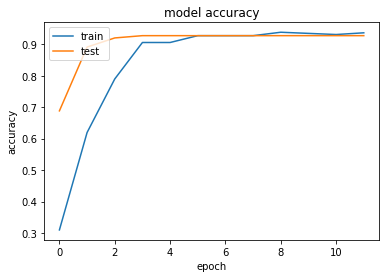

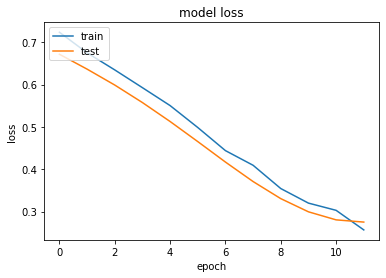

In [438]:
history = model.fit(x_train, y_softmax_train, validation_data=(x_val, y_softmax_val), epochs=12, batch_size=1024,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('lstm_w2v.h5')

### Explanation using LIME

For one example

In [439]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from lime import lime_tabular

In [440]:
y_pred = np.argmax(model.predict(x_val), axis=1)
y_true = y_val
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.93      1.00      0.96       128

    accuracy                           0.93       138
   macro avg       0.46      0.50      0.48       138
weighted avg       0.86      0.93      0.89       138



/home/patrycja/anaconda3/envs/w2w/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
from lime.lime_text import LimeTextExplainer

In [441]:
explainer = LimeTextExplainer(class_names=["NoToxic","Toxic"])

In [442]:
def new_predict_working(x):
    data_temp = np.zeros((len(x), MAX_WORD_NUM), dtype='int32')
    for i, sentence in enumerate(x):
        words = sentence.split(" ")
        for k, word in enumerate(words):
            try:
                if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                    data_temp[i,k] = tokenizer.word_index[word]
            except:
                pass
    return model.predict(data_temp)

In [443]:
def vectorize(x):
    data_temp = np.zeros((len(x), MAX_WORD_NUM), dtype='int32')
    for i, sentence in enumerate(x):
        words = sentence.split(" ")
        for k, word in enumerate(words):
            try:
                if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                    data_temp[i,k] = tokenizer.word_index[word]
            except:
                pass
    return data_temp

In [444]:
string = ' '.join([str(elem) for elem in sentences[15]]) 

In [445]:
exp = explainer.explain_instance(string,new_predict_working , num_features=6, labels=[0,1])

In [446]:
exp.show_in_notebook()

For all samples

In [447]:
class Transform():
    def __init__(self):
        print("")
    
    def fit(self, X, y = None):
        print("")
        return self
    
    def transform(self, X, y =None):
        X_ = vectorize(X)
        return X_
    

In [448]:
t = Transform()

In [449]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(Transform(),model)

In [452]:
exp = explainer.explain_instance(string,c.predict_proba, num_features=6, top_labels = 2)

In [453]:
exp.show_in_notebook()